# Final project - Clickbait classification using RNNs

Name: Amil Salihi

Class: MATH 475

For the final project, I chose a bit more challenging task, as we have not faced this kind of problem in class yet. The project's goal is to develop an model to classify text into clickbait and non-clickbait based on the data from this Kaggle repo: https://www.kaggle.com/datasets/amananandrai/clickbait-dataset. To do the classification, I intend to use RNN models such as LSTM and GRU.

In this notebook, to start it off, I will perform EDA and preprocessing on the data.

## Part 1 - EDA, preprocessing

### Exploratory data analysis

**Data loading and initial check**: The first thing we do is load the dataset and explore the distribution of clickbait and non-clickbait dataset.

Summary from the step: the distribution is approximately 50/50 with around 16000 headlines per class.

In [3]:
import pandas as pd

# Load the dataset to inspect it
data = pd.read_csv('clickbait_data.csv')

data.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [4]:
# Check class distribution to confirm the balance
class_distribution = data['clickbait'].value_counts()
class_distribution

,count
clickbait,
0,16001
1,15999


**Missing data**: The next step would be to learn more about the data itself. With text data, that is not a simple task, and the tools to do so are limited. First, we check if there are any missing data.



In [5]:
# checking for missing values in each column
missing_values = data.isnull().sum()

missing_values

,0
headline,0
clickbait,0


**Word distribution**: There is no missing data, so we can proceed with other tools. What we can do is check the distribution of words in clickbait and non-clickbait headlines.

Summary from the step: the word distribution is similar in both classes, left-skewed histograms. It seems however, that clickbait data contains more of the texts centered aroun 9 words, while the non-clickbait data has a wider spread of word counts, and with the highest bin at 8 words.

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt_tab')
# Plotting distribution of word count for clickbait vs non-clickbait headlines
plt.figure(figsize=(14, 6))

# tokenize into words
data['word_count'] = data['headline'].apply(lambda x: len(nltk.word_tokenize(x)))
data['char_count'] = data['headline'].apply(len)

clickbait_data = data[data['clickbait'] == 1]['word_count']
non_clickbait_data = data[data['clickbait'] == 0]['word_count']

# plotting histogram for word distribution for clickbait vs non-clickbait.
plt.subplot(1, 2, 1)
plt.hist(clickbait_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of word count for clickbait data')
plt.xlabel('Word count')
plt.ylabel('Frequency (number)')

plt.subplot(1, 2, 2)
plt.hist(non_clickbait_data, bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of word count for non-clickbait data')
plt.xlabel('Word count')
plt.ylabel('Frequency (number)')

plt.tight_layout()
plt.show()

__Word Frequency Analysis__: as next step, we can look at the word cloud, which shows the frequency of words appearing for each class.

Summary: Clickbait data has more sensational words in their headlines, while non-clickbait data has more serious words.

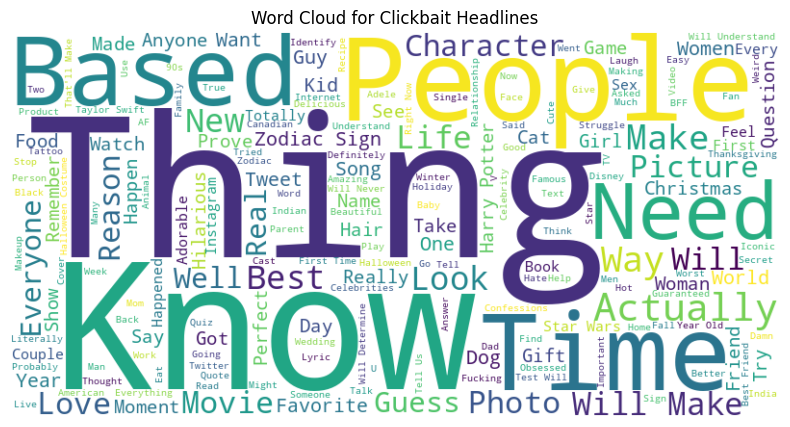

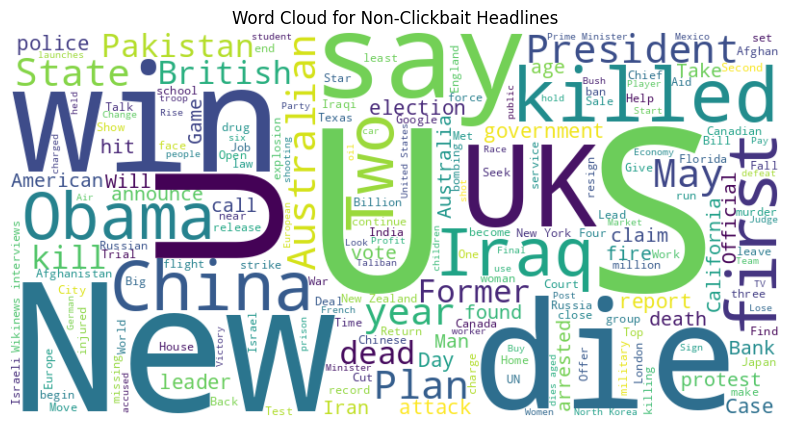

In [7]:
from wordcloud import WordCloud
from collections import Counter

clickbait_headlines = data[data['clickbait'] == 1]['headline']
non_clickbait_headlines = data[data['clickbait'] == 0]['headline']

# word cloud for clickbait headlines
clickbait_text = ' '.join(clickbait_headlines)
clickbait_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clickbait_text)

plt.figure(figsize=(10, 5))
plt.imshow(clickbait_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Clickbait Headlines')
plt.axis('off')
plt.show()

# word cloud for non-clickbait headlines
non_clickbait_text = ' '.join(non_clickbait_headlines)
non_clickbait_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_clickbait_text)

plt.figure(figsize=(10, 5))
plt.imshow(non_clickbait_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Non-Clickbait Headlines')
plt.axis('off')
plt.show()

### Preprocessing

The next step, after EDA, is to preprocess the data. When checking the data (I checked the CSV file so I don't have to load it), the data seems pretty consistent, in that the words are capitalized and barely contain punctuation.

For text data, preprocessign is different than for tabular data and is used for models to learn the text parts better.


For preprocessing, I made custom functions, for which I have provided comments which explain what they do.

For the texts, we do lemmatization and stemmatization, alongside removing punctuation and similar common steps. After that, we split the data in train/test and we create a vectorizer to prepare the data for the model in its understandable way

In [8]:
import tensorflow as tf

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

import re
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

# Line normalizer, convet to lowercase, remove punctuation and maybe stem/lemma.

"""
This function takes a string as input and performs text normalization by
stripping leading and trailing whitespaces, converting the text to lowercase,
removing all non-alphanumeric characters, tokenizing the text, and then
lemmatizing each word using the WordNetLemmatizer. The lemmatized words are
then joined into a single string and returned.
"""


def norm_lemma(line: str):
    line = line.strip().lower()
    line = re.sub(r'[^\w\s]', '', line)
    ret = []
    tokenized = word_tokenize(line)
    for word in tokenized:
        ret.append(wordnet_lemmatizer.lemmatize(word))
    return " ".join(ret)


"""
This function takes a string as input and performs text normalization by
stripping leading and trailing whitespaces, converting the text to lowercase,
removing all non-alphanumeric characters, tokenizing the text, and then
stemming each word using the PorterStemmer. The stemmed words are then joined
into a single string and returned.
"""


def norm_stem(line: str):
    line = line.strip().lower()
    line = re.sub(r'[^\w\s]', '', line)
    ret = []
    tokenized = word_tokenize(line)
    for word in tokenized:
        ret.append(porter_stemmer.stem(word))
    return " ".join(ret)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
from sklearn.model_selection import train_test_split

# Split `data` into train/test set tensors
#
# Also performs shuffling of dataset.


def split_train_test(data: pd.DataFrame, split_size=0.2):
    test = data.sample(frac=split_size, axis=0, random_state=0xc0ffee)
    train = data.drop(index=test.index)
    x_train = tf.convert_to_tensor(train['headline'])
    y_train = tf.convert_to_tensor(train['clickbait'])
    x_test = tf.convert_to_tensor(test['headline'])
    y_test = tf.convert_to_tensor(test['clickbait'])
    return (x_train, y_train, x_test, y_test)

# Create a vectorizer given vocabulary size and maximum length.

def create_vectorizer(vocab_size, max_len):
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_mode='int',
        output_sequence_length=max_len,
        standardize=None)
    return vectorizer

__Preparing data for the model using functions from above__: To do that, now we can use the functions and have the data ready for the model.

In [10]:
# Applying normalization to the dataset
# We'll use norm_lemma to clean and lemmatize the text
data['headline_cleaned'] = data['headline'].apply(norm_lemma)

# Splitting the data into training and testing sets using split_train_test function
x_train, y_train, x_test, y_test = split_train_test(data)

# Using the vectorizer to prepare the data for the LSTM model
# Defining parameters for vectorizer
VOCAB_SIZE = 10000
MAX_LEN = 50

vectorizer = create_vectorizer(VOCAB_SIZE, MAX_LEN)

# Adapting the vectorizer to the training data
vectorizer.adapt(x_train)

# Transforming training and testing data to integer sequences
x_train_vectorized = vectorizer(x_train)
x_test_vectorized = vectorizer(x_test)

# Displaying the shape of the processed data
x_train_vectorized.shape, y_train.shape, x_test_vectorized.shape, y_test.shape

(TensorShape([25600, 50]),
 TensorShape([25600]),
 TensorShape([6400, 50]),
 TensorShape([6400]))

In [11]:
x_train_vectorized

<tf.Tensor: shape=(25600, 50), dtype=int64, numpy=
array([[  48,  106,   87, ...,    0,    0,    0],
       [  35,  154, 1063, ...,    0,    0,    0],
       [   2,   29,  328, ...,    0,    0,    0],
       ...,
       [5014, 7524,    1, ...,    0,    0,    0],
       [3814, 2785,  747, ...,    0,    0,    0],
       [4411, 2417, 3788, ...,    0,    0,    0]])>

### Summary

In this notebook, I explore the data that I will use to create models to classify headlines into clickbait or not. Text data itself is a different form compared to tabular and image data we used so far in class, and it requires specific techniques for EDA, such as word distribution plot and word clouds. We found out that the class distribution is around 50/50, and the different words used in two classes there. Additionally, there is no missing data and word count per headline is similar in both classes. After performing EDA, I was able to preprocess the data in order to prepare it for the model by using techniques such as lemmatization, stemmatization applied to this dataset. After that I created a vectorizer to prepare the data in a form that model that can understand, and thus prepared the data for the next steps.

## Part 2 - Model selection, results

### Helper functions

Here I define helper functions that are used for plotting and displaying the results, as well as for training and validating the model.

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def plot_train_val_loss(history):

    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim(0.3, 0.8)
    plt.show()

def plot_train_val_accuracy(history):

    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [13]:
import numpy as np
# Early stopping with patience 35 that starts from 20 epoch that monitors validation loss.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, start_from_epoch=5)

# Fit a specific model.
# Default batch size is 64 and number of epoch is 300.
# Early stopping is used.


def fit_model(model, batch_size=64, num_epochs=10):
    history = model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[early_stopping])
    return history


# Early stopping with patience 25 that monitors loss.
early_stopping_loss = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=25)

# Fit a model. No validation set is used.


def fit_model_no_val(model, batch_size=64, num_epochs=10):
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[early_stopping_loss])
    return history

# Gets result given model name and histories.
# Returns last, average and min/max accuracy, validation accuracy, loss and validation loss as dataframe.


def get_results(model_names, histories):

    list_of_losses = []
    list_of_accuracies = []
    list_of_val_losses = []
    list_of_val_accuracies = []

    list_of_avg_losses = []
    list_of_avg_accuracies = []
    list_of_avg_val_losses = []
    list_of_avg_val_accuracies = []

    list_of_min_losses = []
    list_of_max_accuracies = []
    list_of_min_val_losses = []
    list_of_max_val_accuracies = []

    results = []
    for history in histories:
        # get the last training loss and append it to list of losses
        list_of_losses.append(history.history['loss'][-1])
        list_of_accuracies.append(history.history['accuracy'][-1])
        list_of_val_losses.append(history.history['val_loss'][-1])
        list_of_val_accuracies.append(history.history['val_accuracy'][-1])

        list_of_avg_losses.append(np.mean(history.history['loss']))
        list_of_avg_accuracies.append(np.mean(history.history['accuracy']))
        list_of_avg_val_losses.append(np.mean(history.history['val_loss']))
        list_of_avg_val_accuracies.append(
            np.mean(history.history['val_accuracy']))

        list_of_min_losses.append(np.min(history.history['loss']))
        list_of_max_accuracies.append(np.max(history.history['accuracy']))
        list_of_min_val_losses.append(np.min(history.history['val_loss']))
        list_of_max_val_accuracies.append(
            np.max(history.history['val_accuracy']))
    results = pd.DataFrame([model_names,
                            list_of_val_losses, list_of_val_accuracies, list_of_losses, list_of_accuracies,
                            list_of_avg_val_losses, list_of_avg_val_accuracies, list_of_avg_losses, list_of_avg_accuracies,
                            list_of_min_val_losses, list_of_max_val_accuracies, list_of_min_losses, list_of_max_accuracies]).T
    results.columns = [
        'Model number', 'Validation loss', 'Validation accuracy', 'Loss', 'Accuracy',
        "Average validation loss", "Average validation accuracy", "Average loss", "Average accuracy",
        "Min val loss", "Max val accuracy", "Min loss", "Max accuracy"]

    return results

### Models - selected choices for comparison (LSTM)

Here I present a few choices for models for comparison. Note: I have tested the models before combining them together (iterative process). Here, for simplicity, I combined them with one run as well as original outlook of functions for a better overview of hyperparameters.

I started by creating a baseline model using a Bidirectional LSTM layer. I chose this architecture because LSTMs are effective in capturing temporal dependencies in sequences, and using a bidirectional layer helps learn from both past and future contexts, which is especially helpful for sequential data. The model uses a vocabulary-based embedding layer, followed by a bidirectional LSTM with 128 units and two dense layers to predict the output. I used a learning rate of 0.001 for the Adam optimizer, which is generally effective for training RNNs. The model is evaluated using accuracy, which is suitable for binary classification tasks.

In [14]:
from tensorflow.keras.regularizers import L1L2

def create_model1(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

To improve model generalization and reduce overfitting, I implemented dropout with a rate of 0.1 after the first dense layer. Dropout helps to prevent the model from becoming overly reliant on specific neurons by randomly setting some of them to zero during training. In this model, I included multiple LSTM layers with increasing numbers of units to capture complex patterns in the data, followed by a dropout layer to improve generalization.

In [15]:
# Model 10 with dropout = 0.10 after first dense layer.


def create_model_dropout01(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.LSTM(32,  return_sequences=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128,  return_sequences=True)),
        tf.keras.layers.LSTM(256),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

In this version of the model, I used L1 regularization (l1=0.005) on the LSTM layer with 256 units to add a penalty on the absolute size of the weights, promoting sparsity in the weights. L1 regularization can be effective in preventing overfitting by simplifying the model, making it easier to generalize to new data.

In [32]:
# Model 10 with l1 = 0.005 at the last hidden layer.


def create_model_l1005(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.LSTM(32,  return_sequences=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128,  return_sequences=True)),
        tf.keras.layers.LSTM(256, kernel_regularizer=L1L2(l1=0.005, l2=0.0)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

In this model, I combined L2 regularization (l2=0.01) on the first and last LSTM layers with a dropout rate of 0.1 after the first dense layer. L2 regularization was chosen to help reduce overfitting by adding a penalty on the magnitude of the weights, encouraging smaller values and preventing the model from becoming overly complex. Dropout (0.1) was added to further reduce overfitting by randomly disabling some of the neurons during training, forcing the network to generalize better.

In [33]:
# Model 10 with l2 = 0.01 at the first and the last hidden layer, and dropout = 0.1 after the first dense layer.


def create_model_l2001Dropout01(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.LSTM(32,  return_sequences=True,
                             kernel_regularizer=L1L2(l1=0.0, l2=0.01)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128,  return_sequences=True)),
        tf.keras.layers.LSTM(256, kernel_regularizer=L1L2(l1=0.0, l2=0.01)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

#### Creating vectorizer

In [34]:
# creating vectorizer
vectorizer = create_vectorizer(2000, 30)

# Adapting vectorizer
vectorizer.adapt(x_train)

#### Creating models from functions

In [35]:
model_1 = create_model1(vectorizer)
model_l1005 = create_model_l1005(vectorizer)
model_l2001dropout01 = create_model_l2001Dropout01(vectorizer)
model_dropout01 = create_model_dropout01(vectorizer)

In [36]:
list_of_models = [model_1, model_l1005,model_l2001dropout01,
                 model_dropout01]

list_of_histories = list(map(fit_model, list_of_models))

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - accuracy: 0.8562 - loss: 0.4941 - val_accuracy: 0.9883 - val_loss: 0.0645
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 77s 144ms/step - accuracy: 0.9935 - loss: 0.0299 - val_accuracy: 0.9865 - val_loss: 0.0856
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 88s 162ms/step - accuracy: 0.9924 - loss: 0.0399 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.9888 - loss: 0.0642 - val_accuracy: 0.9861 - val_loss: 0.1016
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.9975 - loss: 0.0181 - val_accuracy: 0.9912 - val_loss: 0.0577
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - accuracy: 0.9975 - loss: 0.0112 - val_accuracy: 0.9848 - val_loss: 0.1414
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9975 - loss: 0.0149 - val_accuracy: 0.9881 - val_loss: 0.1125
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9985 - loss: 0

#### - GRU models

In this model, I used a Gated Recurrent Unit (GRU) architecture with two 128-unit layers.

In [16]:
# Create GRU with layers 128 and 128 connected
def create_model13_GRU(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(128)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

This model uses a series of GRU layers with increasing units (32, 64, 128), allowing the network to progressively learn more complex temporal patterns.

In [17]:
# Create GRU with 32, 64, 128 & 128 connected layers


def create_model12_GRU(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.GRU(32, return_sequences=True),
        tf.keras.layers.GRU(64, return_sequences=True),
        tf.keras.layers.GRU(128),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

This model combines multiple GRU layers, an LSTM layer, L2 regularization (l2=0.01), and dropout (0.25) for improved generalization and reduced overfitting. The first GRU layer with 32 units includes L2 regularization, which adds a penalty on the weight values, preventing overfitting by encouraging smaller weights.

In [18]:


# Create GRU with 32, 64, 128, 256 & 128 connected layers, dropout 0.25 and l2 = 0.01
def create_model11_GRU_L1L2dropout(vectorizer):
    model = tf.keras.Sequential([
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=len(vectorizer.get_vocabulary()),
            output_dim=32,
            mask_zero=True),
        tf.keras.layers.GRU(32,  return_sequences=True,
                            kernel_regularizer=L1L2(l1=0.0, l2=0.01)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(64,  return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(128,  return_sequences=True)),
        tf.keras.layers.LSTM(256, kernel_regularizer=L1L2(l1=0.0, l2=0.01)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1),
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])
    return model

In [19]:
# Call functions and define models

model_11_GRU_L1L2dropout = create_model11_GRU_L1L2dropout(vectorizer)

model_12_GRU = create_model12_GRU(vectorizer)

model_13_GRU = create_model13_GRU(vectorizer)
########

# store in a list
list_of_models_GRU = [model_11_GRU_L1L2dropout, model_12_GRU, model_13_GRU]

######
# fit list of defined models
list_of_histories_GRU = list(map(fit_model, list_of_models_GRU))

model_names = ["Model 11", "Model 12", "Model 13"]

# get results
results_GRU = get_results(model_names, list_of_histories_GRU)
print(results_GRU)

# evaluate to get test loss and accuracy
test_loss, test_acc = model_11_GRU_L1L2dropout.evaluate(x_test, y_test)
print("Accuracy: ", test_acc, " and test loss: ", test_loss)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 283s 821ms/step - accuracy: 0.8476 - loss: 2.2133 - val_accuracy: 0.9824 - val_loss: 0.3764
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 326s 834ms/step - accuracy: 0.9942 - loss: 0.2205 - val_accuracy: 0.9867 - val_loss: 0.1780
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 321s 831ms/step - accuracy: 0.9970 - loss: 0.0853 - val_accuracy: 0.9867 - val_loss: 0.1362
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 262s 818ms/step - accuracy: 0.9981 - loss: 0.0424 - val_accuracy: 0.9865 - val_loss: 0.1323
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 272s 851ms/step - accuracy: 0.8653 - loss: 2.0926 - val_accuracy: 0.0000e+00 - val_loss: 15.9767
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 265s 830ms/step - accuracy: 0.6232 - loss: 6.0305 - val_accuracy: 0.9957 - val_loss: 0.2265
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 320s 824ms/step - accuracy: 0.9770 - loss: 0.5329 - val_accuracy: 0.9498 - val_loss: 0.8568
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 261s 816ms/step - accuracy: 0.9

#### Model full training and test evaluation

Best overall model: model_dropout01

The best model selected was model_dropout1, which here I train on all the train data (without validation set) and test on the test data.

With the accuracy of: Train 0.9951

In [20]:
model_full_training = create_model_dropout01(vectorizer)

history_full_training_data = fit_model_no_val(model_full_training)

test_loss, test_acc = model_full_training.evaluate(x_test, y_test)
print("Accuracy: ", test_acc, " and test loss: ", test_loss)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 306s 730ms/step - accuracy: 0.7953 - loss: 0.5560
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 290s 726ms/step - accuracy: 0.9890 - loss: 0.0483
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 321s 723ms/step - accuracy: 0.9958 - loss: 0.0235
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 289s 721ms/step - accuracy: 0.9978 - loss: 0.0218
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 327s 735ms/step - accuracy: 0.9983 - loss: 0.0207
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 325s 743ms/step - accuracy: 0.9988 - loss: 0.0177
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 328s 757ms/step - accuracy: 0.9987 - loss: 0.0176
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 315s 740ms/step - accuracy: 0.9988 - loss: 0.0186
Epoch 9/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 294s 735ms/step - accuracy: 0.9988 - loss: 0.0176
Epoch 10/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 322s 736ms/step - accuracy: 0.9972 - loss: 0.0357
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - accuracy: 0.9873 - loss: 0.1586
Accuracy:  0.98750001

200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step


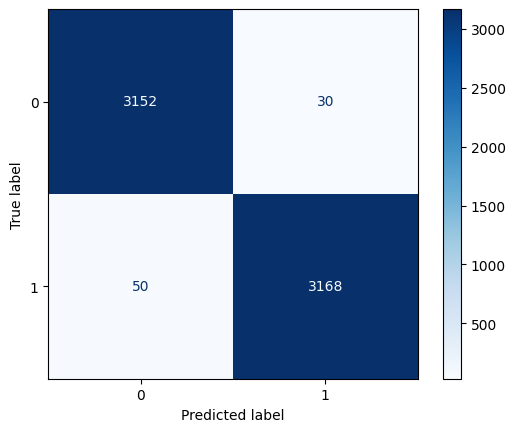

In [23]:
import itertools

predict_x_test = model_full_training.predict(x_test)
flattened_list = list(itertools.chain.from_iterable(predict_x_test))

# Transform the numbers
y_pred = [1 if x >= 0.5 else 0 for x in flattened_list]

# PLOTTING

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Summary

In this project, I have used RNNs for clickbait classification. The RNNs used were LSTM and GRU, which I have compared performance of and found a satistying LSTM model that delivers excellent results.